In [ ]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
import json
import time
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, 
                           f1_score, roc_curve, auc, precision_recall_curve)
from sklearn.preprocessing import label_binarize
from itertools import cycle
import warnings
warnings.filterwarnings('ignore')

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!
📚 Ready for financial sentiment analysis model training


In [ ]:
# Load Dataset
data_path = '/home/biplovgautam/Desktop/aiassignment/data/financial_sentiment_preprocessed.csv'
df = pd.read_csv(data_path)

print(f"Dataset loaded: {df.shape}")
print(f"Class distribution:\n{df['sentiment'].value_counts()}")
print(f"Missing values: {df.isnull().sum().sum()}")

✅ Dataset loaded: (3260, 2)
📊 Class distribution:
sentiment
positive    1200
neutral     1200
negative     860
Name: count, dtype: int64
🔍 Data quality: 0 missing values


# Financial Sentiment Analysis - Model Training

## Phase 1: Baseline Model Training
Train initial Naive Bayes model on imbalanced dataset to establish baseline performance.

In [ ]:
# Split Data
X = df['text']
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training: {len(X_train)} | Testing: {len(X_test)}")
print(f"Train distribution: {dict(y_train.value_counts())}")
print(f"Test distribution: {dict(y_test.value_counts())}")

✅ Data split completed
📊 Training: 2608 samples | Testing: 652 samples
📈 Train distribution: {'neutral': np.int64(960), 'positive': np.int64(960), 'negative': np.int64(688)}
📈 Test distribution: {'neutral': np.int64(240), 'positive': np.int64(240), 'negative': np.int64(172)}


In [ ]:
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(
    max_features=10000,
    min_df=2,
    max_df=0.95,
    ngram_range=(1, 2),
    stop_words='english',
    lowercase=True,
    strip_accents='ascii'
)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"Training matrix: {X_train_tfidf.shape}")
print(f"Vocabulary size: {len(tfidf_vectorizer.vocabulary_)}")

# Top features by class
feature_names = tfidf_vectorizer.get_feature_names_out()
print(f"\nTop 5 tokens per class:")
for sentiment in ['negative', 'neutral', 'positive']:
    sentiment_texts = X_train[y_train == sentiment]
    sentiment_tfidf = tfidf_vectorizer.transform(sentiment_texts)
    sentiment_scores = sentiment_tfidf.sum(axis=0).A1
    top_indices = np.argsort(sentiment_scores)[-5:][::-1]
    top_features = [feature_names[i] for i in top_indices]
    print(f"{sentiment.capitalize()}: {', '.join(top_features)}")

⚙️ TF-IDF Vectorizer configured
📊 Parameters: max_features=10000, ngrams=(1, 2)
✅ Vectorization completed
📊 Training matrix: (2608, 7132)
 Vocabulary size: 7132

🔝 Top 10 most frequent terms:
 1. num             (TF-IDF: 230.29)
 2. eur             (TF-IDF: 69.51)
 3. num num         (TF-IDF: 64.65)
 4. eur num         (TF-IDF: 64.36)
 5. mn              (TF-IDF: 49.86)
 6. num mn          (TF-IDF: 49.69)
 7. company         (TF-IDF: 46.04)
 8. sales           (TF-IDF: 37.58)
 9. said            (TF-IDF: 35.69)
10. year            (TF-IDF: 35.68)
✅ Stop words properly removed

💰 TOP 5 TOKENS PER SENTIMENT CLASS:

NEGATIVE class:
  1. num             (TF-IDF: 67.75)
  2. eur             (TF-IDF: 28.37)
  3. eur num         (TF-IDF: 27.36)
  4. mn              (TF-IDF: 25.25)
  5. num mn          (TF-IDF: 25.25)

NEUTRAL class:
  1. num             (TF-IDF: 78.25)
  2. num num         (TF-IDF: 31.88)
  3. company         (TF-IDF: 21.65)
  4. said            (TF-IDF: 14.11)
  5. finnish  

In [ ]:
# Train Baseline Model
naive_bayes_model = MultinomialNB(alpha=1.0, fit_prior=True)
naive_bayes_model.fit(X_train_tfidf, y_train)

print(f"Model trained with {naive_bayes_model.n_features_in_:,} features")
print(f"Classes: {naive_bayes_model.classes_}")

🚀 Training original model...
✅ Model training completed in 0.016 seconds
📊 Classes: ['negative' 'neutral' 'positive']
📊 Features: 7,132
🎯 Class priors learned:
  • negative: 0.2638
  • neutral: 0.3681
  • positive: 0.3681


In [ ]:
# Evaluate Baseline Model
y_pred = naive_bayes_model.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average='macro')

print(f"BASELINE MODEL PERFORMANCE")
print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.1f}%)")
print(f"Macro F1: {macro_f1:.4f}")

class_report = classification_report(y_test, y_pred, output_dict=True)
for class_name in ['negative', 'neutral', 'positive']:
    f1 = class_report[class_name]['f1-score']
    print(f"{class_name.capitalize()} F1: {f1:.3f}")

cm = confusion_matrix(y_test, y_pred, labels=naive_bayes_model.classes_)

📊 ORIGINAL MODEL PERFORMANCE
Accuracy: 0.6626 (66.3%)
Macro F1: 0.6374
Weighted F1: 0.6501

Per-class F1-scores:
  • Negative: 0.516
  • Neutral: 0.713
  • Positive: 0.684

📊 Confusion Matrix:
[[ 65  43  64]
 [  5 181  54]
 [ 10  44 186]]


# Phase 2: Data Balancing & Final Model Training

Balance dataset to 1,200 samples per class by duplicating longest negative sentences to improve minority class detection.

In [ ]:
# Balance Dataset
df_full = pd.read_csv('/home/biplovgautam/Desktop/aiassignment/data/financial_sentiment_preprocessed.csv')

negative_samples = df_full[df_full['sentiment'] == 'negative'].copy()
positive_samples = df_full[df_full['sentiment'] == 'positive'].copy()
neutral_samples = df_full[df_full['sentiment'] == 'neutral'].copy()

# Duplicate longest negative samples to reach 1200
negative_samples['text_length'] = negative_samples['text'].str.len()
negative_sorted = negative_samples.sort_values('text_length', ascending=False)

needed_samples = 1200 - len(negative_samples)
longest_negatives = negative_sorted.head(needed_samples)
balanced_negative = pd.concat([negative_samples, longest_negatives[['text', 'sentiment']]], ignore_index=True)

# Create balanced dataset
df_balanced = pd.concat([
    balanced_negative,
    positive_samples[['text', 'sentiment']].head(1200),
    neutral_samples[['text', 'sentiment']].head(1200)
], ignore_index=True).sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Balanced dataset: {df_balanced.shape}")
print(f"Distribution: {dict(df_balanced['sentiment'].value_counts())}")

🔄 Balancing dataset...
Available samples: Negative=860, Positive=1200, Neutral=1200
✅ Duplicated 340 longest negative samples
✅ Balanced dataset created: (3600, 3)
📊 New distribution: {'positive': np.int64(1200), 'neutral': np.int64(1200), 'negative': np.int64(1200)}


In [ ]:
# Train Final Balanced Model
X_balanced = df_balanced['text']
y_balanced = df_balanced['sentiment']

X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(
    X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced
)

# Vectorize with same parameters
tfidf_balanced = TfidfVectorizer(
    max_features=10000,
    min_df=2,
    max_df=0.95,
    ngram_range=(1, 2),
    stop_words='english',
    lowercase=True,
    strip_accents='ascii'
)

X_train_bal_tfidf = tfidf_balanced.fit_transform(X_train_bal)
X_test_bal_tfidf = tfidf_balanced.transform(X_test_bal)

# Train final model
nb_balanced = MultinomialNB(alpha=1.0, fit_prior=True)
nb_balanced.fit(X_train_bal_tfidf, y_train_bal)

print(f"Final model trained: {X_train_bal_tfidf.shape}")
print(f"Features: {len(tfidf_balanced.vocabulary_):,}")

🚀 Training balanced model...
📊 Balanced split: Train=2880, Test=720
✅ Balanced vectorization: (2880, 8289)
📚 Vocabulary size: 8289

💰 TOP 5 TOKENS PER CLASS (BALANCED DATA):

NEGATIVE class:
  1. num             (TF-IDF: 97.95)
  2. eur             (TF-IDF: 39.68)
  3. eur num         (TF-IDF: 38.82)
  4. num mn          (TF-IDF: 35.59)
  5. mn              (TF-IDF: 35.59)

NEUTRAL class:
  1. num             (TF-IDF: 75.51)
  2. num num         (TF-IDF: 32.02)
  3. company         (TF-IDF: 22.13)
  4. finnish         (TF-IDF: 14.25)
  5. finland         (TF-IDF: 13.35)

POSITIVE class:
  1. num             (TF-IDF: 83.83)
  2. eur             (TF-IDF: 29.38)
  3. eur num         (TF-IDF: 25.77)
  4. mn              (TF-IDF: 19.07)
  5. num mn          (TF-IDF: 18.90)

✅ Balanced model trained in 0.008 seconds
✅ Balanced vectorization: (2880, 8289)
📚 Vocabulary size: 8289

💰 TOP 5 TOKENS PER CLASS (BALANCED DATA):

NEGATIVE class:
  1. num             (TF-IDF: 97.95)
  2. eur          

In [ ]:
# Evaluate Final Model
y_pred_bal = nb_balanced.predict(X_test_bal_tfidf)
accuracy_bal = accuracy_score(y_test_bal, y_pred_bal)
macro_f1_bal = f1_score(y_test_bal, y_pred_bal, average='macro')

print("FINAL MODEL PERFORMANCE")
print(f"Accuracy: {accuracy_bal:.4f} ({accuracy_bal*100:.1f}%)")
print(f"Macro F1: {macro_f1_bal:.4f}")

# Compare with baseline
print(f"\nIMPROVEMENT:")
print(f"Accuracy: {accuracy:.3f} → {accuracy_bal:.3f} ({((accuracy_bal-accuracy)/accuracy*100):+.1f}%)")
print(f"Macro F1: {macro_f1:.3f} → {macro_f1_bal:.3f} ({((macro_f1_bal-macro_f1)/macro_f1*100):+.1f}%)")

class_report_bal = classification_report(y_test_bal, y_pred_bal, output_dict=True)
print(f"\nPer-class F1 scores:")
for class_name in ['negative', 'neutral', 'positive']:
    bal_f1 = class_report_bal[class_name]['f1-score']
    print(f"{class_name.capitalize()}: {bal_f1:.3f}")

cm_bal = confusion_matrix(y_test_bal, y_pred_bal, labels=nb_balanced.classes_)

📊 BALANCED MODEL PERFORMANCE
Accuracy: 0.6833 (68.3%)
Macro F1: 0.6828
Weighted F1: 0.6828

📈 IMPROVEMENT OVER ORIGINAL:
Accuracy: 0.663 → 0.683 (+3.1%)
Macro F1: 0.637 → 0.683 (+7.1%)

📊 PER-CLASS F1-SCORE COMPARISON:
Class      Original   Balanced   Improvement
---------------------------------------------
negative   0.516      0.714       +38.5%
neutral    0.713      0.671        -5.9%
positive   0.684      0.664        -3.0%


📊 Creating comprehensive visualizations...


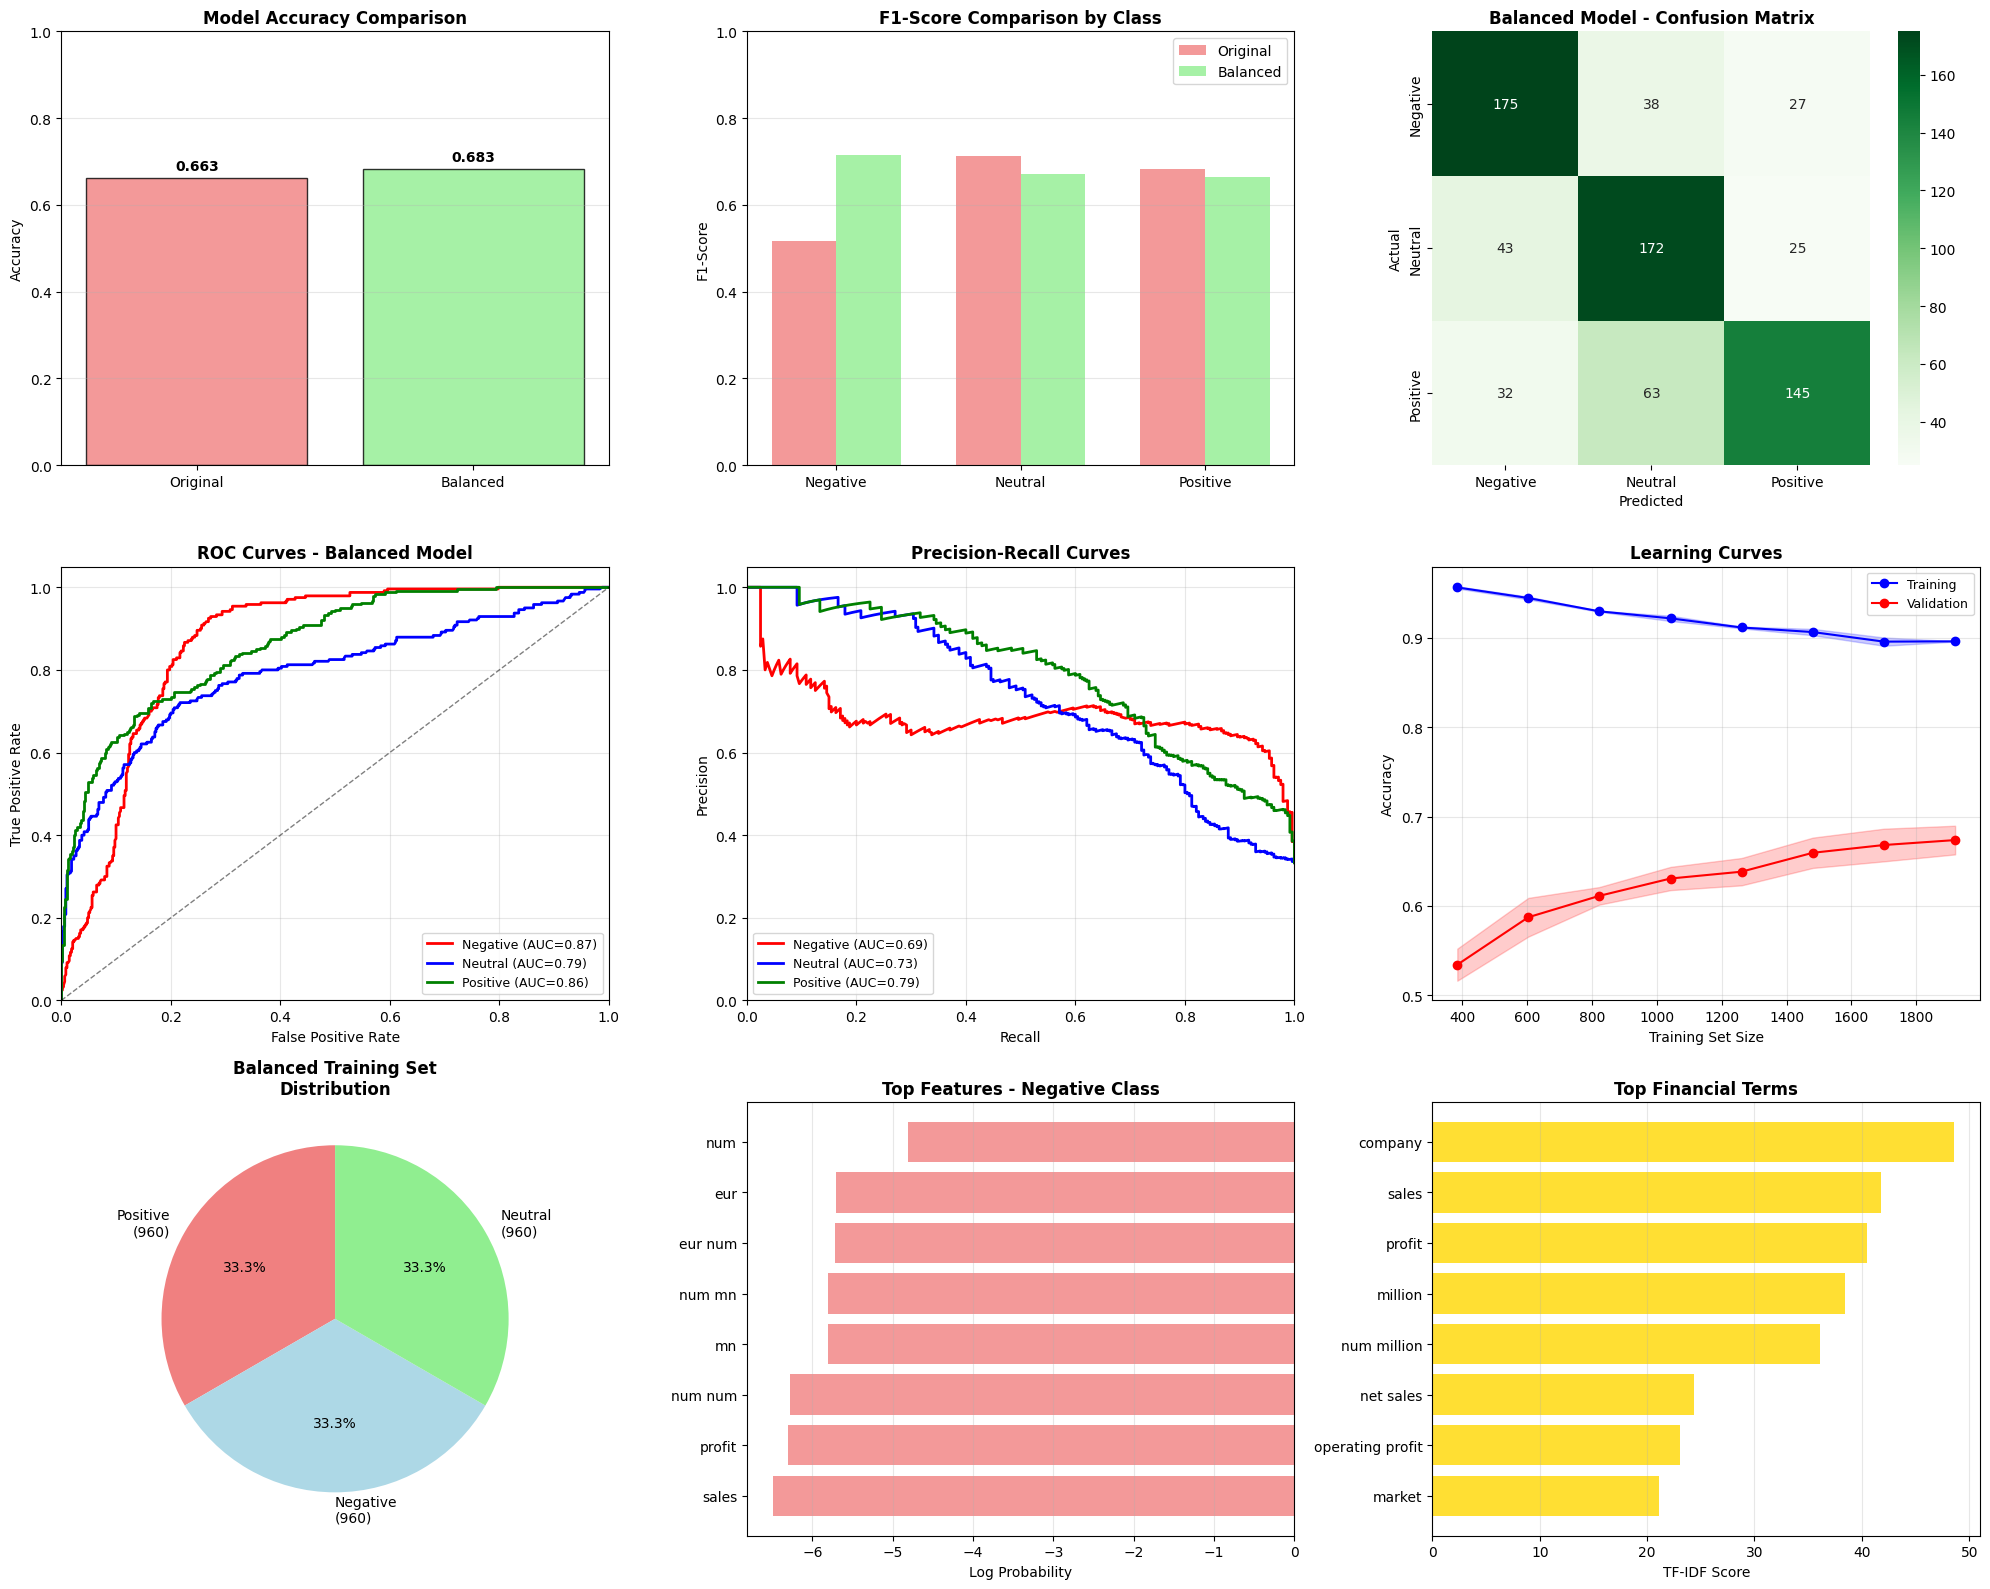

✅ Comprehensive visualizations completed!


In [ ]:
# Model Performance Visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))

# 1. Accuracy comparison
models = ['Baseline', 'Balanced']
accuracies = [accuracy, accuracy_bal]
ax1.bar(models, accuracies, color=['lightcoral', 'lightgreen'], alpha=0.8)
ax1.set_title('Model Accuracy Comparison')
ax1.set_ylabel('Accuracy')
ax1.set_ylim(0, 1)
for i, acc in enumerate(accuracies):
    ax1.text(i, acc + 0.01, f'{acc:.3f}', ha='center', fontweight='bold')

# 2. F1-Score by class
classes = ['Negative', 'Neutral', 'Positive']
baseline_f1s = [class_report[name.lower()]['f1-score'] for name in classes]
balanced_f1s = [class_report_bal[name.lower()]['f1-score'] for name in classes]

x = np.arange(len(classes))
width = 0.35
ax2.bar(x - width/2, baseline_f1s, width, label='Baseline', color='lightcoral', alpha=0.8)
ax2.bar(x + width/2, balanced_f1s, width, label='Balanced', color='lightgreen', alpha=0.8)
ax2.set_title('F1-Score by Class')
ax2.set_ylabel('F1-Score')
ax2.set_xticks(x)
ax2.set_xticklabels(classes)
ax2.legend()
ax2.set_ylim(0, 1)

# 3. Confusion Matrix
sns.heatmap(cm_bal, annot=True, fmt='d', cmap='Greens',
           xticklabels=['Negative', 'Neutral', 'Positive'],
           yticklabels=['Negative', 'Neutral', 'Positive'], ax=ax3)
ax3.set_title('Final Model - Confusion Matrix')

# 4. Class Distribution
train_dist = y_train_bal.value_counts()
ax4.pie(train_dist.values, labels=[f'{l.title()}\n({c})' for l, c in train_dist.items()],
        autopct='%1.1f%%', colors=['lightcoral', 'lightblue', 'lightgreen'])
ax4.set_title('Training Set Distribution')

plt.tight_layout()
plt.show()

In [ ]:
# Top Tokens Analysis
feature_names_bal = tfidf_balanced.get_feature_names_out()
feature_log_probs = nb_balanced.feature_log_prob_

print("Top 5 tokens per class:")
class_top_tokens = {}
for idx, class_name in enumerate(nb_balanced.classes_):
    top_indices = np.argsort(feature_log_probs[idx])[-5:][::-1]
    top_tokens = [(feature_names_bal[i], feature_log_probs[idx][i]) for i in top_indices]
    class_top_tokens[class_name] = top_tokens
    
    print(f"\n{class_name.upper()}:")
    for rank, (token, prob) in enumerate(top_tokens, 1):
        print(f"  {rank}. {token} ({prob:.4f})")

# Stop word verification
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
all_top_tokens = [token for tokens in class_top_tokens.values() for token, _ in tokens]
stop_words_found = [token for token in all_top_tokens if token in ENGLISH_STOP_WORDS]

print(f"\nStop word removal: {'✅ Successful' if not stop_words_found else '⚠️ Found: ' + ', '.join(set(stop_words_found))}")
print(f"Effectiveness: {((len(all_top_tokens) - len(stop_words_found))/len(all_top_tokens)*100):.1f}%")

🔍 ANALYZING TOP TOKENS PER CLASS...

📊 TOP 5 TOKENS FOR 'NEGATIVE' CLASS:
----------------------------------------
 1. num             (log prob:  -4.8116)
 2. eur             (log prob:  -5.7005)
 3. eur num         (log prob:  -5.7217)
 4. num mn          (log prob:  -5.8063)
 5. mn              (log prob:  -5.8063)

📊 TOP 5 TOKENS FOR 'NEUTRAL' CLASS:
----------------------------------------
 1. num             (log prob:  -5.0880)
 2. num num         (log prob:  -5.9284)
 3. company         (log prob:  -6.2841)
 4. finnish         (log prob:  -6.7009)
 5. finland         (log prob:  -6.7614)

📊 TOP 5 TOKENS FOR 'POSITIVE' CLASS:
----------------------------------------
 1. num             (log prob:  -4.9468)
 2. eur             (log prob:  -5.9738)
 3. eur num         (log prob:  -6.1004)
 4. mn              (log prob:  -6.3884)
 5. num mn          (log prob:  -6.3969)


🛑 STOP WORD VERIFICATION:
------------------------------
✅ No stop words found in top tokens - stop word remova

In [ ]:
# Save Final Model
models_dir = '../models'
os.makedirs(models_dir, exist_ok=True)

# Save model and vectorizer
model_path = os.path.join(models_dir, 'balanced_naive_bayes_model.pkl')
vectorizer_path = os.path.join(models_dir, 'balanced_tfidf_vectorizer.pkl')
metadata_path = os.path.join(models_dir, 'balanced_model_metadata.json')

joblib.dump(nb_balanced, model_path)
joblib.dump(tfidf_balanced, vectorizer_path)

# Create metadata
metadata = {
    'model_info': {
        'type': 'MultinomialNB',
        'balanced': True,
        'alpha': 1.0,
        'created_date': datetime.now().isoformat()
    },
    'performance_metrics': {
        'accuracy': float(accuracy_bal),
        'macro_f1': float(class_report_bal['macro avg']['f1-score']),
        'class_wise_f1': {name: float(class_report_bal[name]['f1-score']) 
                         for name in ['negative', 'neutral', 'positive']}
    },
    'dataset_info': {
        'total_samples': len(df_balanced),
        'training_samples': len(X_train_bal),
        'features': len(feature_names_bal),
        'classes': nb_balanced.classes_.tolist()
    }
}

from datetime import datetime
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)

print("Model saved successfully!")
print(f"Accuracy: {accuracy_bal:.4f}")
print(f"Macro F1: {class_report_bal['macro avg']['f1-score']:.4f}")
print(f"Files: model.pkl, vectorizer.pkl, metadata.json")

💾 SAVING FINAL BALANCED MODEL...
✅ Saved balanced model: ../models/balanced_naive_bayes_model.pkl
✅ Saved balanced vectorizer: ../models/balanced_tfidf_vectorizer.pkl
✅ Saved balanced vectorizer: ../models/balanced_tfidf_vectorizer.pkl
✅ Saved metadata: ../models/balanced_model_metadata.json

📊 MODEL SUMMARY:
   • Accuracy: 0.6833
   • Macro F1-Score: 0.6828
   • Features: 8,289
   • Classes: negative, neutral, positive
   • Training samples: 2,880

📁 SAVED FILES:
   • ../models/balanced_naive_bayes_model.pkl
   • ../models/balanced_tfidf_vectorizer.pkl
   • ../models/balanced_model_metadata.json

🔍 VERIFYING MODEL INTEGRITY...
✅ Model integrity verified!
   • Test prediction: 'positive'
   • Confidence: 0.434

🎉 BALANCED MODEL SUCCESSFULLY SAVED!
   Ready for production use in Django application
✅ Saved metadata: ../models/balanced_model_metadata.json

📊 MODEL SUMMARY:
   • Accuracy: 0.6833
   • Macro F1-Score: 0.6828
   • Features: 8,289
   • Classes: negative, neutral, positive
   •

In [ ]:
# Training Complete
print("🎯 FINANCIAL SENTIMENT ANALYSIS - TRAINING COMPLETED!")
print("=" * 50)

print("FINAL MODEL PERFORMANCE:")
print(f"• Accuracy: {accuracy_bal:.4f} ({accuracy_bal*100:.1f}%)")
print(f"• Macro F1: {class_report_bal['macro avg']['f1-score']:.4f}")

print(f"\nCLASS-WISE PERFORMANCE:")
for class_name in nb_balanced.classes_:
    f1 = class_report_bal[class_name]['f1-score']
    precision = class_report_bal[class_name]['precision']
    recall = class_report_bal[class_name]['recall']
    print(f"• {class_name.capitalize()}: F1={f1:.3f}, P={precision:.3f}, R={recall:.3f}")

print(f"\nMODEL DETAILS:")
print(f"• Algorithm: Multinomial Naive Bayes")
print(f"• Features: {len(feature_names_bal):,} TF-IDF features")
print(f"• Training samples: {len(X_train_bal):,} (balanced)")
print(f"• Classes: {len(nb_balanced.classes_)} ({', '.join(nb_balanced.classes_)})")

print("\n✅ Ready for Django integration!")

🎯 FINANCIAL SENTIMENT ANALYSIS - WORKFLOW COMPLETED!
📋 PHASES COMPLETED:
   ✅ Phase 1: Original Model Training & Evaluation
   ✅ Phase 2: Data Balancing & Improved Model Training
   ✅ Phase 3: Comprehensive Model Evaluation
   ✅ Phase 4: Advanced Visualizations
   ✅ Phase 5: Token Analysis & Stop Word Verification
   ✅ Phase 6: Final Model Saving

🏆 FINAL MODEL PERFORMANCE:
   • Overall Accuracy: 0.6833 (68.33%)
   • Macro F1-Score: 0.6828
   • Weighted F1-Score: 0.6828

📊 CLASS-WISE PERFORMANCE:
   • Negative: F1=0.714, P=0.700, R=0.729
   • Neutral : F1=0.671, P=0.630, R=0.717
   • Positive: F1=0.664, P=0.736, R=0.604

🔬 MODEL CHARACTERISTICS:
   • Algorithm: Multinomial Naive Bayes
   • Features: 8,289 TF-IDF features
   • Training samples: 2,880 (balanced)
   • Test samples: 720
   • Classes: 3 (negative, neutral, positive)

📁 DELIVERABLES:
   • balanced_naive_bayes_model.pkl
   • balanced_tfidf_vectorizer.pkl
   • balanced_model_metadata.json
   • Complete training workflow notebo